In [ ]:
%pip install pandas scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


Datos de la competencia

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip -l udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Carga de datos

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (692500, 21)
Test shape: (296786, 20)


Limpieza y optimización

In [ ]:
X = train_df.drop(columns=["RENDIMIENTO_GLOBAL"])
y = train_df["RENDIMIENTO_GLOBAL"]

print(f"Clases únicas en y: {y.unique()}")
print(f"Distribución de clases:")
print(y.value_counts())

# Codificar la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nClases codificadas: {label_encoder.classes_}")
print(f"Mapeo: {dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))}")

# Detectar columnas categóricas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nColumnas categóricas: {categorical_features}")
print(f"Número de columnas categóricas: {len(categorical_features)}")

# Limpiar NaN categóricas
for col in categorical_features:
    X[col] = X[col].fillna("Unknown")

# Limpiar NaN numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

# OPTIMIZACIÓN: Usar LabelEncoder para categóricas en lugar de one-hot encoding
categorical_encoders = {}
X_processed = X.copy()

for col in categorical_features:
    # Limitar categorías para reducir memoria
    value_counts = X[col].value_counts()
    
    # Mantener solo las top 20 categorías más frecuentes
    top_categories = value_counts.head(20).index.tolist()
    
    # Reemplazar categorías raras con "Other"
    X_processed[col] = X_processed[col].apply(
        lambda x: x if x in top_categories else "Other"
    )
    
    # Aplicar LabelEncoder
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])
    categorical_encoders[col] = le
    
    print(f"Columna {col}: {len(le.classes_)} categorías únicas")

# Convertir a tipos de datos más eficientes
for col in X_processed.columns:
    if X_processed[col].dtype == 'float64':
        X_processed[col] = X_processed[col].astype('float32')
    elif X_processed[col].dtype == 'int64':
        X_processed[col] = X_processed[col].astype('int32')

print(f"\nShape final: {X_processed.shape}")
print(f"Memoria significativamente reducida ✅")

Clases únicas en y: ['medio-alto' 'bajo' 'alto' 'medio-bajo']
Distribución de clases:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64

Clases codificadas: ['alto' 'bajo' 'medio-alto' 'medio-bajo']
Mapeo: {0: 'alto', 1: 'bajo', 2: 'medio-alto', 3: 'medio-bajo'}

Columnas categóricas: ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE']
Número de columnas categóricas: 14
Columna ESTU_PRGM_ACADEMICO: 21 categorías únicas
Columna ESTU_PRGM_ACADEMICO: 21 categorías únicas
Columna ESTU_PRGM_DEPARTAMENTO: 21 categorías únicas
Columna ESTU_PRGM_DEPARTAMENTO: 21 categorías únicas
Columna ESTU_VALORMATRICULAUNIVERSIDAD: 9 cat

Entrenamiento del modelo

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Clases en y_train: {np.unique(y_train)}")

# Modelo optimizado para memoria
model = LogisticRegression(
    max_iter=1000, 
    multi_class='multinomial', 
    solver='lbfgs',
    C=1.0,  # Regularización para evitar sobreajuste
    random_state=42
)

print("Entrenando modelo...")
model.fit(X_train, y_train)
print("✅ Modelo entrenado correctamente")


X_train shape: (554000, 20)
y_train shape: (554000,)
Clases en y_train: [0 1 2 3]
Entrenando modelo...


C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Modelo entrenado correctamente


C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluación del modelo


Accuracy en validación: 0.3363249097472924

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto       0.41      0.58      0.48     35124
        bajo       0.31      0.28      0.30     34597
  medio-alto       0.27      0.13      0.17     34324
  medio-bajo       0.30      0.35      0.32     34455

    accuracy                           0.34    138500
   macro avg       0.32      0.34      0.32    138500
weighted avg       0.32      0.34      0.32    138500

              precision    recall  f1-score   support

        alto       0.41      0.58      0.48     35124
        bajo       0.31      0.28      0.30     34597
  medio-alto       0.27      0.13      0.17     34324
  medio-bajo       0.30      0.35      0.32     34455

    accuracy                           0.34    138500
   macro avg       0.32      0.34      0.32    138500
weighted avg       0.32      0.34      0.32    138500



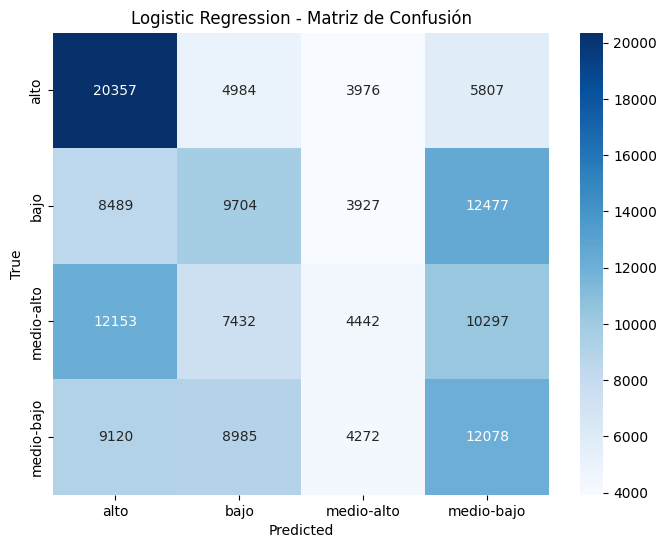

In [ ]:
y_pred = model.predict(X_val)

# Convertir predicciones de vuelta a labels originales para mostrar
y_val_labels = label_encoder.inverse_transform(y_val)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\nAccuracy en validación:", accuracy_score(y_val, y_pred))
print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val_labels, y_pred_labels))

# Matriz de confusión con labels originales
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Logistic Regression - Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Test y submisión

In [ ]:
X_test = test_df.drop(columns=['RENDIMIENTO_GLOBAL'], errors='ignore')

# Aplicar el mismo preprocesamiento que al train
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna("Unknown")
        
for col in numeric_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna(X[col].median())

# Aplicar el mismo procesamiento categórico optimizado
X_test_processed = X_test.copy()

for col in categorical_features:
    if col in X_test_processed.columns and col in categorical_encoders:
        # Obtener las categorías del encoder de entrenamiento
        train_categories = categorical_encoders[col].classes_
        
        # Aplicar la misma lógica de top categorías
        X_test_processed[col] = X_test_processed[col].apply(
            lambda x: x if x in train_categories else "Other"
        )
        
        # Aplicar el encoder entrenado
        try:
            X_test_processed[col] = categorical_encoders[col].transform(X_test_processed[col])
        except ValueError:
            # Si hay categorías nuevas, asignar valor por defecto
            X_test_processed[col] = X_test_processed[col].apply(
                lambda x: categorical_encoders[col].transform([x])[0] 
                if x in train_categories else 0
            )

# Convertir a tipos de datos eficientes
for col in X_test_processed.columns:
    if X_test_processed[col].dtype == 'float64':
        X_test_processed[col] = X_test_processed[col].astype('float32')
    elif X_test_processed[col].dtype == 'int64':
        X_test_processed[col] = X_test_processed[col].astype('int32')

# Asegurar que test tenga las mismas columnas que train
X_test_processed = X_test_processed.reindex(columns=X_processed.columns, fill_value=0)

print(f"X_test_processed shape: {X_test_processed.shape}")
print(f"X_train shape: {X_processed.shape}")

print("\nGenerando predicciones sobre test...")
test_pred_encoded = model.predict(X_test_processed)

# Convertir predicciones de vuelta a labels originales
test_pred = label_encoder.inverse_transform(test_pred_encoded)

# Detección de columna ID
test_id_col = None
for possible_id in ["ID", "id", "index", "row_id"]:
    if possible_id in test_df.columns:
        test_id_col = possible_id
        break

if test_id_col is None:
    print("⚠ No se encontró columna ID, generando índices como ID")
    test_ids = range(len(test_pred))
    test_id_col = "ID"
else:
    test_ids = test_df[test_id_col]

submission = pd.DataFrame({
    test_id_col: test_ids,
    "RENDIMIENTO_GLOBAL": test_pred
})

print(f"\nDistribución de predicciones:")
print(pd.Series(test_pred).value_counts())

submission.to_csv("submission_logistic.csv", index=False)
print(f"\n✅ 'submission_logistic.csv' generado correctamente con {submission.shape[0]} filas")
print(f"Archivo guardado en: {os.path.abspath('submission_logistic.csv')}")